In [112]:
import sys, os, json
from scf_guess_tools import Backend
import numpy as np
sys.path.append('../src/')
from scf_guess_datasets import Qm9Isomeres, Qm9IsomeresMd, Qm9
import matplotlib.pyplot as plt
from uncertainties import ufloat
import scf_guess_datasets, pickle
from utils import find_repo_root
project_root_dir = find_repo_root()
print("Project root directory:", project_root_dir)

BASIS_PATH = os.path.join(project_root_dir, "scripts/6-31g_2df_p_custom_nwchem.gbs")

Project root directory: /home/etschgi1/REPOS/Masterarbeit


In [113]:
local_pc_path = os.path.join(project_root_dir, "datasets/QM9")
isomers = Qm9Isomeres(
    local_pc_path, 
    size = 500, # number of molecules to load
    val=0.1, # using 80% training / 10 % val / 10% test split
    test=0.1,
)
isomers_md = Qm9IsomeresMd(
    local_pc_path, 
    size = 500, # number of molecules to load
    val=0.1, # using 80% training / 10 % val / 10% test split
    test=0.1,
)
qm9 = Qm9(
    local_pc_path, 
    size = 500, # number of molecules to load
    val=0.1, # using 80% training / 10 % val / 10% test split
    test=0.1,
)

In [114]:
def energy_elec(fock, density, coreH): 
    return np.trace((fock+coreH) @ density)

def energy_err(e_pred, e_conv): 
    return e_conv - e_pred, e_pred/e_conv -1

def diis_rmse(overlap, density, fock): 
    """Eq 2.3 - Milacher"""
    E = fock @ density @ overlap - overlap @ density @ fock
    diis_rmse_ = np.sqrt(np.linalg.norm(E, ord='fro')**2 / (density.shape[0]**2))
    return diis_rmse_

In [115]:
def eval_py_scf_guesses(dataset: scf_guess_datasets.Qm9Isomeres | scf_guess_datasets.Qm9IsomeresMd | scf_guess_datasets.Qm9):
    
    #energy
    rel_e_all = {}
    for scheme in dataset.schemes:
        e, rel_e, diis, rmse = [], [], [], []
        for test_key in dataset.test_keys:
            
            H = dataset.solution(test_key).hcore
            ovlp = dataset.solution(test_key).overlap

            D0 = dataset.guesses(test_key)[scheme].density
            F0 = dataset.guesses(test_key)[scheme].fock
            E0 = energy_elec(F0, D0, H)

            Dc = dataset.solution(test_key).density
            Fc = dataset.solution(test_key).fock
            Ec = energy_elec(Fc, Dc, H)

            e.append(energy_err(E0, Ec)[0])
            rel_e.append(energy_err(E0, Ec)[1])
            diis.append(diis_rmse(ovlp, D0, F0))
            rmse.append(np.sqrt(np.mean((D0 - Dc)**2)))
        rel_e_all[scheme] = [abs(x) for x in rel_e] 
        e = (np.mean(e), np.std(e))
        diis = (np.mean(diis), np.std(diis))
        rel_e = (np.mean(rel_e), np.std(rel_e))
        rmse = (np.mean(rmse), np.std(rmse))
        print(f"Scheme: {scheme}, Energy Error: {e},  Relative Energy Error: {rel_e}, DIIS RMSE: {diis}, RMSE: {rmse}")
    plt.figure(figsize=(10, 6))
    all_vals = [v for vals in rel_e_all.values() for v in vals if v > 0]
    vmin = max(min(all_vals), 1e-12)
    vmax = max(all_vals)

    bins = np.logspace(np.floor(np.log10(vmin)),
                    np.ceil(np.log10(vmax)),
                    30)
    for scheme in dataset.schemes:
        plt.hist(rel_e_all[scheme], bins=bins, alpha=0.5, label=scheme)

    plt.xlabel("Relative Energy Error")
    plt.ylabel("Count")
    plt.xscale('log')
    plt.title("Relative Energy Error Distribution per Scheme")
    plt.legend()
    plt.xlim(1e-4, 1)
    plt.grid(True, alpha=0.3)


Dataset: qm9_isomeres
Scheme: 1e, Energy Error: (-222.96653507557755, 32.57686205081529),  Relative Energy Error: (-0.1277590530353433, 0.01937030445916676), DIIS RMSE: (0.1220736410385737, 0.010290911875349857), RMSE: (0.14230736941837302, 0.04107371462073853)
Scheme: vsap, Energy Error: (-5.382962002229892, 0.4363384810687355),  Relative Energy Error: (-0.003079608979696635, 0.00021261283528152054), DIIS RMSE: (0.02564531934802158, 0.0020032134646657527), RMSE: (0.010855640359685146, 0.000649471974127452)
Scheme: sap, Energy Error: (-13.52719965772285, 4.469733138221624),  Relative Energy Error: (-0.0077530824745319134, 0.0026014055724433603), DIIS RMSE: (0.043820736288622396, 0.007527025807184349), RMSE: (0.015983536647527042, 0.0019424291535285966)
Scheme: minao, Energy Error: (2.8321950206020254, 0.24214249178748923),  Relative Energy Error: (0.0016204683517088635, 0.00012193470175009684), DIIS RMSE: (0.07733587291383215, 0.002676063777164556), RMSE: (0.015504270001251567, 0.00035

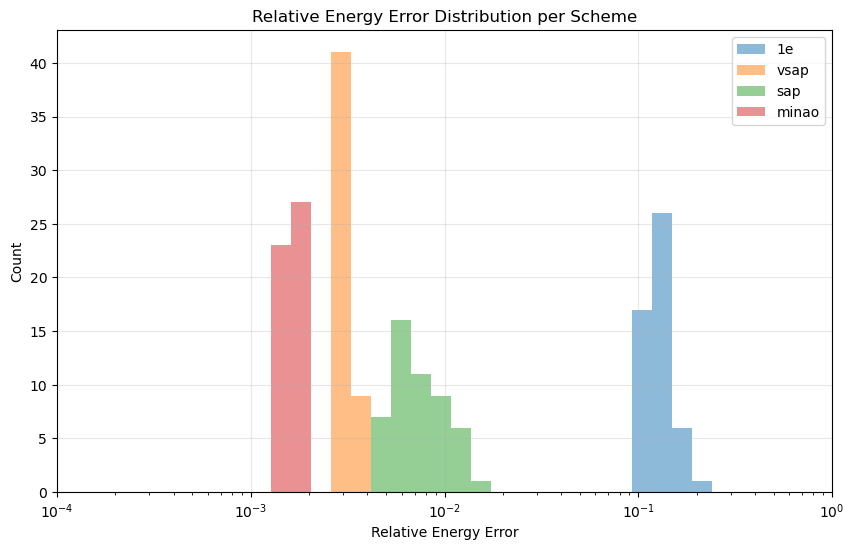

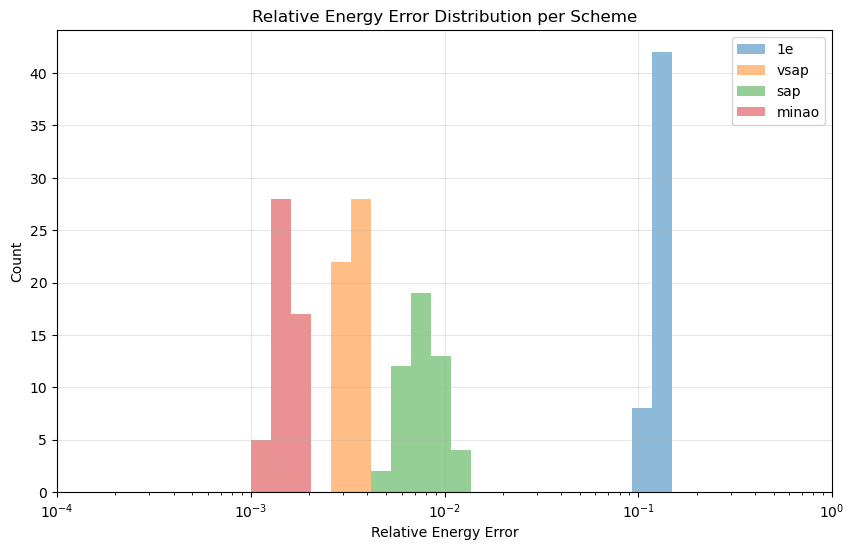

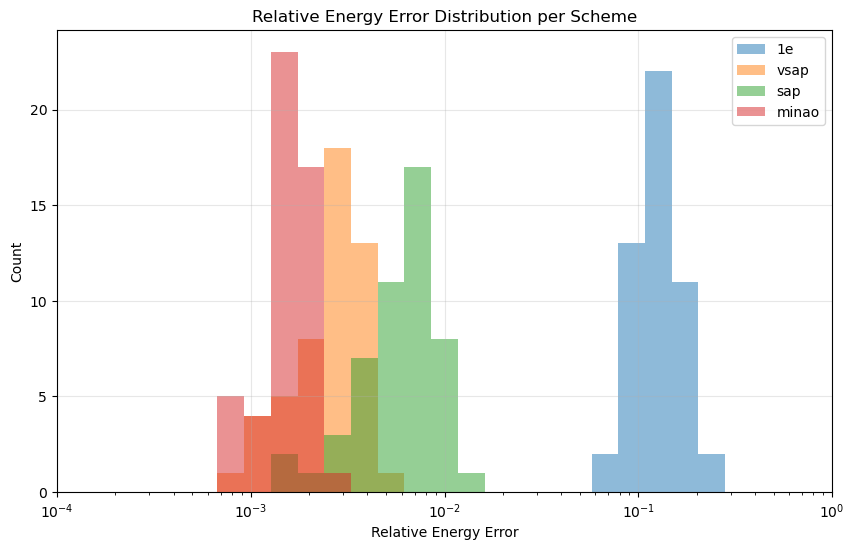

In [116]:

for dataset in [isomers, isomers_md, qm9]:
    print("================================")
    print(f"Dataset: {dataset.name}")
    eval_py_scf_guesses(dataset)
    

In [117]:
# dummy evals: 

def eval_dummy(dataset, dummy_guess_density, dummy_guess_fock): 
    e, rel_e, diis, rmse = [], [], [], []
    for test_key in dataset.test_keys:
        H = dataset.solution(test_key).hcore
        ovlp = dataset.solution(test_key).overlap
        D0 = dummy_guess_density
        F0 = dummy_guess_fock
        E0 = energy_elec(F0, D0, H)
        Dc = dataset.solution(test_key).density
        Fc = dataset.solution(test_key).fock
        Ec = energy_elec(Fc, Dc, H)
        e.append(energy_err(E0, Ec)[0])
        rel_e.append(energy_err(E0, Ec)[1])
        diis.append(diis_rmse(ovlp, D0, F0))
        rmse.append(np.sqrt(np.mean((D0 - Dc)**2)))
    e = (np.mean(e), np.std(e))
    diis = (np.mean(diis), np.std(diis))
    rel_e = (np.mean(rel_e), np.std(rel_e))
    rmse = (np.mean(rmse), np.std(rmse))
    print(f"Scheme: Dummy, Energy Error: {e},  Relative Energy Error: {rel_e}, DIIS RMSE: {diis}, RMSE: {rmse}")

In [118]:
for dataset in [isomers, isomers_md]: # qm9 guess not that easy -> see /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/6-31g_full_testing/dummy_eval.ipynb
    print("================================")
    print(f"Dataset: {dataset.name}")
    conv_density_train = [dataset.solution(test_key).density for test_key in dataset.train_keys]
    conv_fock_train = [dataset.solution(test_key).fock for test_key in dataset.train_keys]
    density_guess_dummy = np.mean(conv_density_train, axis=0)
    fock_guess_dummy = np.mean(conv_fock_train, axis=0)
    eval_dummy(dataset, density_guess_dummy, fock_guess_dummy)

Dataset: qm9_isomeres
Scheme: Dummy, Energy Error: (-210.98787175397817, 5.876520968056226),  Relative Energy Error: (-0.12078711586729377, 0.0019197084819484896), DIIS RMSE: (0.11009873718889868, 0.002638977747074212), RMSE: (0.013749488364321267, 0.0004011258533748653)
Dataset: qm9_isomeres_md
Scheme: Dummy, Energy Error: (-207.54170853979372, 5.829744273307134),  Relative Energy Error: (-0.11735795359683053, 0.002783299149330025), DIIS RMSE: (0.10348749640130443, 0.004019085504411797), RMSE: (0.013433892643880879, 0.00028719132509102475)
